In [19]:
import json
import operator
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation, writers
from matplotlib.patches import Rectangle
from IPython.core.display import HTML
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
from scipy.io import wavfile
from scipy.signal import periodogram

In [20]:
threats = [[ele['text'], ele['score']] for ele in msg['sentiment']['targets']]
emotions = [[ele['text'], max(ele['emotion'].items(), key=operator.itemgetter(1))[0].upper()] for ele in msg['keywords']]

def map_emotion(text, emotions):
    
    for ele in emotions:
        if text.endswith(ele[0]): 
            return ele[1]
        
    return 'NEUTRAL'

def map_priority(text, threats):
    
    for ele in threats: 
        if ele[0] in text: return 'HIGH'
    if 'broken' in text: return 'MEDIUM'
    
    return 'LOW'

In [21]:
def interpolate(t_inp, t_out, val):

    if len(val) < len(t_out):
        f = interp1d(t_inp, val, kind='linear', fill_value='extrapolate')
        return f(t_out)

    if len(val) == len(t_out):
        return val

    if len(val) > len(t_out):
        f = interp1d(t_inp, val, kind='quadratic')
        return f(t_out)

In [22]:
rte, wav = wavfile.read('audios/call_911_2.wav')
with open('audios/call_911_2.json', 'r') as raw: log = json.load(raw)
v_beg = np.asarray(log['starts'])
v_end = np.asarray(log['ends'])
words = np.asarray(log['words'])

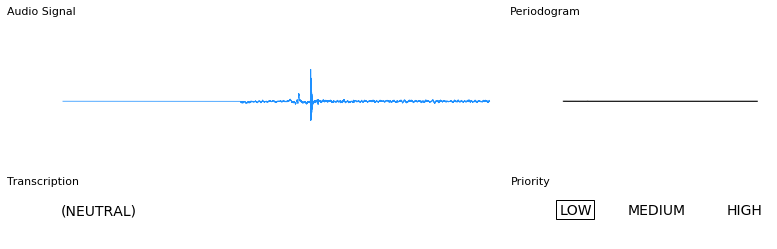

In [23]:
beg, samplerate = 0, rte
low, top = 0, 1

emo = 'NEUTRAL'
tns = 'LOW'
length = len(wav) / rte
wds = ' '.join(words[v_end < top][-7:])

sig = wav[max(0, int(low*rte)):min(wav.shape[0], int(top*rte))][:,0]
sig = interpolate(np.arange(len(sig)), np.arange(samplerate), sig)

f,z = periodogram(sig, fs=rte)
msk = f < (samplerate / 50)
f,z = f[msk], z[msk]

fig = plt.figure(figsize=(13, 4))
gds = gridspec.GridSpec(4, 3)

ax1 = plt.subplot(gds[:3,:2], frameon=False)
s_1, = ax1.plot(sig, c='dodgerblue', lw=0.75)
ax1.set_title('Audio Signal', x=0, fontsize=11)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylim([-max(np.abs(wav[:,0])), max(np.abs(wav[:,0]))])

ax2 = plt.subplot(gds[:3,2], frameon=False)
s_2, = ax2.plot(f, z, c='black', lw=1.0)
ax2.hlines(0.0, 0.0, max(f), lw=0.5)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_title('Periodogram', x=-0.04, fontsize=11)
ax2.set_ylim([-300000.0, 300000.0])

ax3 = plt.subplot(gds[3,:2], frameon=False)
t_0 = ax3.text(4, 5, '(' + emo + ')', fontsize=14)
t_1 = ax3.text(25, 5, wds, fontsize=14)
ax3.set_yticks([])
ax3.set_xticks([])
ax3.set_title('Transcription', x=0.005, fontsize=11)
ax3.set_xlim([0, 100])
ax3.set_ylim([0, 10])

ax4 = plt.subplot(gds[3,2], frameon=False)
ax4.text(-148, 0, 'LOW', fontsize=14)
ax4.text(-80, 0, 'MEDIUM', fontsize=14)
ax4.text(20, 0, 'HIGH', fontsize=14)
ax4.set_yticks([])
ax4.set_xticks([])
ax4.set_xlim([-154, 60])
ax4.set_ylim([-20, 20])
ax4.set_title('Priority', x=-0.105, fontsize=11)
if tns == 'LOW': ax4.add_artist(Rectangle((-152, -4), len(list(tns))*13, 16, fill=False))
if tns == 'MEDIUM': ax4.add_artist(Rectangle((-87, -4), len(list(tns))*12, 16, fill=False))
if tns == 'HIGH': ax4.add_artist(Rectangle((15, -4), len(list(tns))*11, 16, fill=False))

plt.show()

In [24]:
def update(frame_number):

    beg = frame_number
    low, top = frame_number/30, (frame_number/30)+1
    wds = ' '.join(words[v_end < top][-7:])
    
    tmp = map_emotion(wds, emotions)
    if tmp != 'NEUTRAL': emo = '(' + tmp + ')'
    try: assert(type(emo)) == str
    except: emo = '(' + 'NEUTRAL' + ')'
    
    tmp = map_priority(wds, threats)
    try: assert(type(tns)) == str
    except: tns = 'LOW'
    if (tmp == 'MEDIUM' or tmp == 'HIGH') and tns == 'LOW': tns = tmp
    elif tmp == 'HIGH' and (tns == 'MEDIUM' or tns == 'LOW'): tns = tmp

    sig = wav[max(0, int(low*rte)):min(wav.shape[0], int(top*rte))][:,0]
    sig = interpolate(np.arange(len(sig)), np.arange(samplerate), sig)

    f,z = periodogram(sig, fs=rte)
    msk = f < (samplerate / 50)
    f,z = f[msk], z[msk]
    
    s_1.set_ydata(sig)
    s_2.set_ydata(z)
    t_0.set_text(emo)
    t_1.set_text(wds)
    
    ax4.artists[-1].remove()
    if tns == 'LOW': ax4.add_artist(Rectangle((-152, -4), len(list(tns))*13, 16, fill=False))
    if tns == 'MEDIUM': ax4.add_artist(Rectangle((-87, -4), len(list(tns))*12, 16, fill=False))
    if tns == 'HIGH': ax4.add_artist(Rectangle((15, -4), len(list(tns))*11, 16, fill=False))

animation = FuncAnimation(fig, update, interval=30, frames=int(30*length))
Writer = writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Meryll Dindin'), bitrate=1800)
animation.save('sound_animation_0.mp4', writer=writer)